<a href="https://colab.research.google.com/github/ese-ada-lovelace-2024/Gems4-draupnir/blob/main/Ashwin's%203Dnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot

In [ ]:
## Imports
import os, random
import numpy as np

#DeepLearning Torch
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import ShuffleSplit

from livelossplot import PlotLosses

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#randomizer
def set_seed(seed):
  """
  Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.benchmark = False # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. Useful when inputs do not change size
  torch.backends.cudnn.enabled = False

  return True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob, random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class PreprocessorAuto(Dataset):
    """
    GPU‐friendly Dataset: only the target is per‐sample normalized
    to zero‐mean/unit‐variance; inputs are left at their raw scales.
    """
    def __init__(self,
                 split='train',
                 sample_size=150,
                 target='pressure_buildup',
                 normalize=True,
                 pad_mode='zero',
                 H=96,
                 W=200,
                 seed=42,
                 device=None):
        assert device is not None, "Please pass a torch device"
        self.device    = device
        self.target    = target
        self.normalize = normalize
        self.pad_mode  = pad_mode
        self.H, self.W  = H, W

        # 1) gather file paths
        train_dir = "/content/drive/MyDrive/train_data_set"
        val_dir   = "/content/drive/MyDrive/GEMS4-CCS/val_data_set"
        all_train = sorted(glob.glob(os.path.join(train_dir, '*.npz')))

        if split in ('train','val'):
            random.seed(seed + (0 if split=='train' else 1))
            n = min(sample_size, len(all_train))
            self.paths = random.sample(all_train, n)
        else:
            self.paths = sorted(glob.glob(os.path.join(val_dir, '*.npz')))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        with np.load(path) as data:
            # shapes from gas_saturation
            gas = data['gas_saturation']
            orig_H, orig_W, T = gas.shape
            H, W = self.H, self.W

            # coordinate grids on GPU
            xs = torch.arange(H, device=self.device)
            ys = torch.arange(W, device=self.device)
            ts = torch.arange(T, device=self.device)
            X, Y, Z = torch.meshgrid(xs, ys, ts, indexing='ij')  # each (H,W,T)

            arrs = {}
            for k in data.files:
                v_np = data[k]

                # 2) perforation mask
                if k=='perf_interval':
                    z0, z1 = int(v_np[0]), int(v_np[1])
                    mask2d = torch.zeros((H,W), device=self.device)
                    mask2d[z0:z1, :] = 1.0
                    arrs[k] = mask2d.unsqueeze(-1).repeat(1,1,T)
                    continue

                # move data to GPU
                v = torch.from_numpy(v_np.astype(np.float32)).to(self.device)

                # 3) dynamic 3D fields (including the target)
                if v.ndim==3 and v.shape==(orig_H, orig_W, T):
                    out = torch.zeros((H,W,T), device=self.device)
                    for t in range(T):
                        sl = v[...,t]
                        # per‐slice standardization for the target only
                        if self.normalize and k==self.target:
                            μ, σ = sl.mean(), sl.std()
                            sl = (sl - μ)/σ if σ>0 else sl-μ
                        # pad 2d → (H,W)
                        pad = (0, W - sl.shape[1], 0, H - sl.shape[0])
                        val = 0.0 if self.pad_mode=='zero' else sl.mean()
                        out[:,:,t] = F.pad(sl, pad, mode='constant', value=val)
                    arrs[k] = out

                # 4) static 2D maps
                elif v.ndim==2 and v.shape==(orig_H, orig_W):
                    a2 = v
                    pad = (0, W - a2.shape[1], 0, H - a2.shape[0])
                    val = 0.0 if self.pad_mode=='zero' else a2.mean()
                    a2 = F.pad(a2, pad, mode='constant', value=val)
                    arrs[k] = a2.unsqueeze(-1).repeat(1,1,T)

                # 5) scalars → broadcast
                elif v.ndim==0 or v.numel()==1:
                    arrs[k] = torch.full((H,W,T), float(v.item()), device=self.device)

                else:
                    raise ValueError(f"Cannot broadcast '{k}' shape {v.shape}")

            # 6) add coordinate channels
            arrs['grid_x'] = X
            arrs['grid_y'] = Y
            arrs['grid_t'] = Z

            # 7) drop the other target
            other = 'gas_saturation' if self.target=='pressure_buildup' else 'pressure_buildup'
            arrs.pop(other, None)

            # 8) stack inputs vs target
            input_keys  = [k for k in arrs if k!=self.target]
            target_keys = [self.target]

            inp = torch.stack([arrs[k] for k in input_keys], dim=0)   # (C,H,W,T)
            tgt = torch.stack([arrs[k] for k in target_keys], dim=0)  # (1,H,W,T)

            # 9) permute to (C,T,H,W)
            inputs = inp.permute(0,3,1,2).contiguous()
            target = tgt.permute(0,3,1,2).contiguous()

        return {
            'inputs': inputs,             # (C, T, H, W)
            'target': target,             # (1, T, H, W)
            'x':       X.permute(2,0,1).long(),
            'y':       Y.permute(2,0,1).long(),
            'time':    Z.permute(2,0,1).long(),
            'in_keys': input_keys,
            'tg_keys': target_keys,
            'original_height': orig_H,
            'original_width':  orig_W
        }


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import operator
from functools import reduce
from functools import partial

torch.manual_seed(0)

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()
        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class U_net(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dropout_rate):
        super(U_net, self).__init__()
        self.input_channels = input_channels
        self.conv1 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=2, dropout_rate = dropout_rate)
        self.conv2 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=2, dropout_rate = dropout_rate)
        self.conv2_1 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=1, dropout_rate = dropout_rate)
        self.conv3 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=2, dropout_rate = dropout_rate)
        self.conv3_1 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=1, dropout_rate = dropout_rate)

        self.deconv2 = self.deconv(input_channels, output_channels)
        self.deconv1 = self.deconv(input_channels*2, output_channels)
        self.deconv0 = self.deconv(input_channels*2, output_channels)

        self.output_layer = self.output(input_channels*2, output_channels,
                                         kernel_size=kernel_size, stride=1, dropout_rate = dropout_rate)


    def forward(self, x):
        out_conv1 = self.conv1(x)
        out_conv2 = self.conv2_1(self.conv2(out_conv1))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_deconv2 = self.deconv2(out_conv3)
        concat2 = torch.cat((out_conv2, out_deconv2), 1)
        out_deconv1 = self.deconv1(concat2)
        concat1 = torch.cat((out_conv1, out_deconv1), 1)
        out_deconv0 = self.deconv0(concat1)
        concat0 = torch.cat((x, out_deconv0), 1)
        out = self.output_layer(concat0)

        return out

    def conv(self, in_planes, output_channels, kernel_size, stride, dropout_rate):
        return nn.Sequential(
            nn.Conv3d(in_planes, output_channels, kernel_size=kernel_size,
                      stride=stride, padding=(kernel_size - 1) // 2, bias = False),
            nn.BatchNorm3d(output_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout_rate)
        )

    def deconv(self, input_channels, output_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(input_channels, output_channels, kernel_size=4,
                               stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def output(self, input_channels, output_channels, kernel_size, stride, dropout_rate):
        return nn.Conv3d(input_channels, output_channels, kernel_size=kernel_size,
                         stride=stride, padding=(kernel_size - 1) // 2)



class SimpleBlock3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(SimpleBlock3d, self).__init__()
        """
        U-FNO contains 3 Fourier layers and 3 U-Fourier layers.

        input shape: (batchsize, x=200, y=96, t=24, c=12)
        output shape: (batchsize, x=200, y=96, t=24, c=1)
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.fc0 = nn.Linear(12, self.width)
        """
        12 channels for [kr, kz, porosity, inj_loc, inj_rate,
                         pressure, temperature, Swi, Lam,
                         grid_x, grid_y, grid_t]
        """
        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv4 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv5 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.unet3 = U_net(self.width, self.width, 3, 0)
        self.unet4 = U_net(self.width, self.width, 3, 0)
        self.unet5 = U_net(self.width, self.width, 3, 0)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]

        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x3 = self.unet3(x)
        x = x1 + x2 + x3
        x = F.relu(x)

        x1 = self.conv4(x)
        x2 = self.w4(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x3 = self.unet4(x)
        x = x1 + x2 + x3
        x = F.relu(x)

        x1 = self.conv5(x)
        x2 = self.w5(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x3 = self.unet5(x)
        x = x1 + x2 + x3
        x = F.relu(x)

        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

class Net3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(Net3d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock3d(modes1, modes2, modes3, width)


    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]
        x = F.pad(F.pad(x, (0,0,0,8,0,8), "replicate"), (0,0,0,0,0,0,0,8), 'constant', 0)
        x = self.conv1(x)
        x = x.view(batchsize, size_x+8, size_y+8, size_z+8, 1)[..., :-8,:-8,:-8, :]
        return x.squeeze()


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import r2_score
import os
import glob

# 1) Data
# train_ds = PreprocessorAuto(split='train', target='pressure_buildup',
#                             normalize=True, pad_mode='zero', H=96, W=200)
# val_ds   = PreprocessorAuto(split='val',   target='pressure_buildup',
#                             normalize=True, pad_mode='zero', H=96, W=200)

device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_ds = PreprocessorAuto(
    split='train',
    sample_size=1000,
    target='gas_saturation',
    normalize=True,
    pad_mode='zero',
    H=96,
    W=200,
    seed=42,
    device=device
)

# only 20 random files for validation
val_ds = PreprocessorAuto(
    split='val',
    sample_size=100,
    target='gas_saturation',
    normalize=True,
    pad_mode='zero',
    H=96,
    W=200,
    seed=42,
    device=device
)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=0, pin_memory=False)


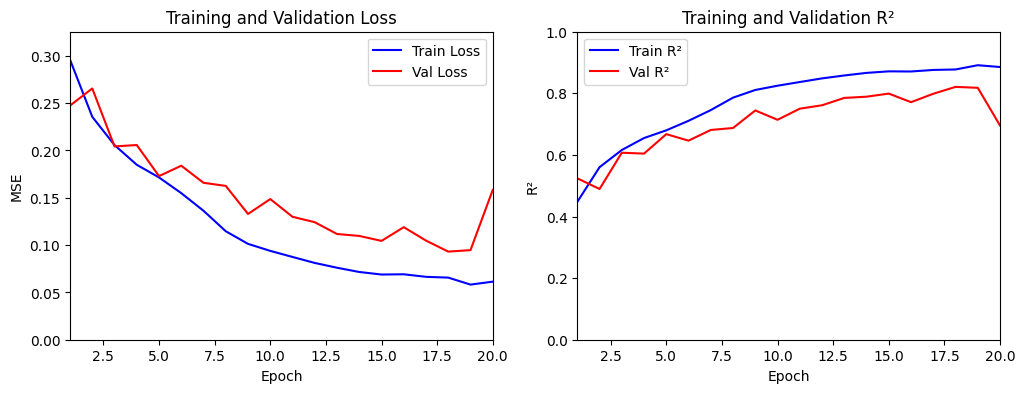

Epoch 20/20  Train L= 0.0614,  Val L= 0.1583,Train_R2= 0.8854, Val_R2= 0.6955


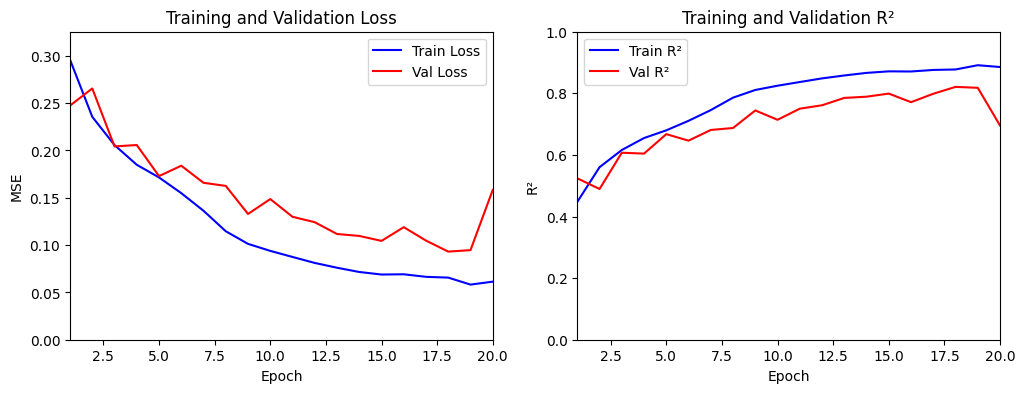

In [ ]:
# 2) Model, optimizer, loss
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model        = Net3d(modes1=16, modes2=16, modes3=16, width=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
criterion    = nn.MSELoss()

# 3) Prepare live plot
plt.ion()
fig, (ax_loss, ax_r2) = plt.subplots(1,2, figsize=(12,4))
ax_loss.set_title("Training and Validation Loss");  ax_loss.set_xlabel("Epoch");  ax_loss.set_ylabel("MSE")
ax_r2.set_title("Training and Validation R²");    ax_r2.set_xlabel("Epoch");    ax_r2.set_ylabel("R²")
line_tl, = ax_loss.plot([], [], 'b-', label='Train Loss')
line_vl, = ax_loss.plot([], [], 'r-', label='Val Loss')
ax_loss.legend()
line_tr2, = ax_r2.plot([], [], 'b-', label='Train R²')
line_vr2, = ax_r2.plot([], [], 'r-', label='Val R²')
ax_r2.legend()

train_losses, val_losses = [], []
train_r2s,    val_r2s    = [], []

best_val_loss = float('inf')
ckpt_path     = "/content/drive/MyDrive/best_model_gassat.pth"

# 4) Training loop
num_epochs = 20
for epoch in range(1, num_epochs+1):
    # --- train ---
    model.train()
    running_loss = 0.0
    all_preds, all_truth = [], []
    for batch in train_loader:
        x = batch['inputs'].permute(0,3,4,2,1).to(device)      # (B,H,W,T,C)
        y = batch['target'].permute(0,3,4,2,1).squeeze(-1).to(device)  # (B,H,W,T)

        optimizer.zero_grad()
        y_pred = model(x)                                        # (B,H,W,T)
        loss   = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        sched.step()

        running_loss += loss.item() * x.size(0)
        all_preds.append(y_pred.detach().cpu().flatten())
        all_truth.append(y.detach().cpu().flatten())
    train_loss = running_loss / len(train_ds)
    train_pred = torch.cat(all_preds).numpy()
    train_true = torch.cat(all_truth).numpy()
    train_r2   = r2_score(train_true, train_pred)

    # --- validate ---
    model.eval()
    running_loss = 0.0
    all_preds, all_truth = [], []
    with torch.no_grad():
        for batch in val_loader:
            x = batch['inputs'].permute(0,3,4,2,1).to(device)
            y = batch['target'].permute(0,3,4,2,1).squeeze(-1).to(device)
            y_pred = model(x)
            loss   = criterion(y_pred, y)
            running_loss += loss.item() * x.size(0)
            all_preds.append(y_pred.cpu().flatten())
            all_truth.append(y.cpu().flatten())
    val_loss = running_loss / len(val_ds)
    val_pred = torch.cat(all_preds).numpy()
    val_true = torch.cat(all_truth).numpy()
    val_r2   = r2_score(val_true, val_pred)

    # --- checkpoint best ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), ckpt_path)

    # --- record & live‐plot ---
    train_losses.append(train_loss);  val_losses.append(val_loss)
    train_r2s.append(train_r2);       val_r2s.append(val_r2)

    line_tl.set_data(range(1,epoch+1), train_losses)
    line_vl.set_data(range(1,epoch+1), val_losses)
    ax_loss.set_xlim(1, num_epochs);  ax_loss.set_ylim(0, max(val_losses+train_losses)*1.1)

    line_tr2.set_data(range(1,epoch+1), train_r2s)
    line_vr2.set_data(range(1,epoch+1), val_r2s)
    ax_r2.set_xlim(1, num_epochs);    ax_r2.set_ylim(0, 1.0)

    clear_output(wait=True)
    display(fig)

    print(f"Epoch {epoch}/{num_epochs}  Train L= {train_loss:.4f},  Val L= {val_loss:.4f},Train_R2= {train_r2:.4f}, Val_R2= {val_r2:.4f}")

plt.ioff()

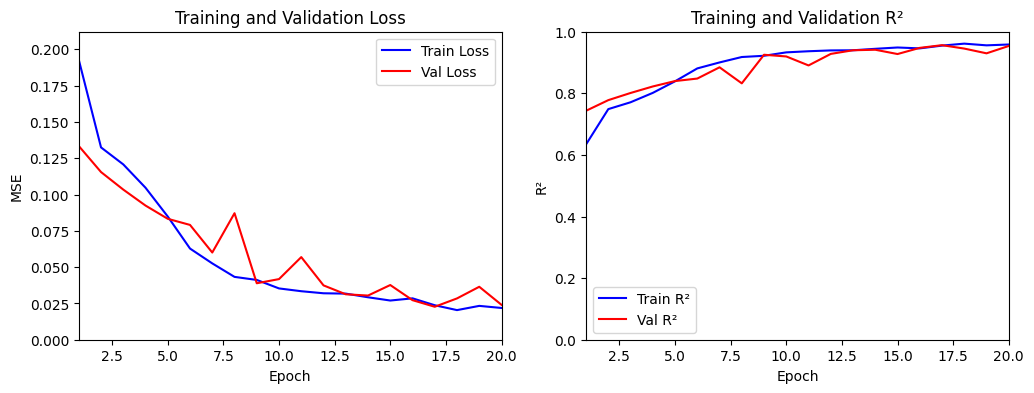

Epoch 20/20  Train L= 0.0219,  Val L= 0.0240,Train_R2= 0.9585, Val_R2= 0.9538


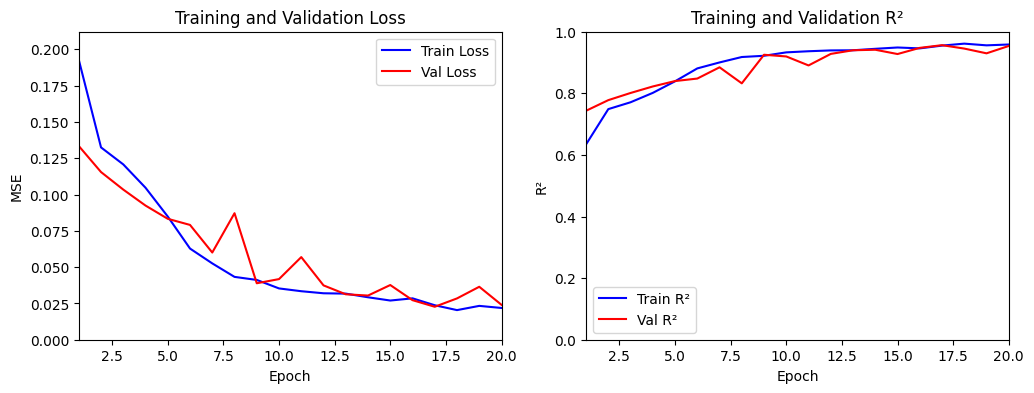

In [ ]:
# 2) Model, optimizer, loss
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model        = Net3d(modes1=16, modes2=16, modes3=16, width=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
criterion    = nn.MSELoss()

# 3) Prepare live plot
plt.ion()
fig, (ax_loss, ax_r2) = plt.subplots(1,2, figsize=(12,4))
ax_loss.set_title("Training and Validation Loss");  ax_loss.set_xlabel("Epoch");  ax_loss.set_ylabel("MSE")
ax_r2.set_title("Training and Validation R²");    ax_r2.set_xlabel("Epoch");    ax_r2.set_ylabel("R²")
line_tl, = ax_loss.plot([], [], 'b-', label='Train Loss')
line_vl, = ax_loss.plot([], [], 'r-', label='Val Loss')
ax_loss.legend()
line_tr2, = ax_r2.plot([], [], 'b-', label='Train R²')
line_vr2, = ax_r2.plot([], [], 'r-', label='Val R²')
ax_r2.legend()

train_losses, val_losses = [], []
train_r2s,    val_r2s    = [], []

best_val_loss = float('inf')
ckpt_path     = "/content/drive/MyDrive/best_model_gassat.pth"

# 4) Training loop
num_epochs = 20
for epoch in range(1, num_epochs+1):
    # --- train ---
    model.train()
    running_loss = 0.0
    all_preds, all_truth = [], []
    for batch in train_loader:
        x = batch['inputs'].permute(0,3,4,2,1).to(device)      # (B,H,W,T,C)
        y = batch['target'].permute(0,3,4,2,1).squeeze(-1).to(device)  # (B,H,W,T)

        optimizer.zero_grad()
        y_pred = model(x)                                        # (B,H,W,T)
        loss   = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        sched.step()

        running_loss += loss.item() * x.size(0)
        all_preds.append(y_pred.detach().cpu().flatten())
        all_truth.append(y.detach().cpu().flatten())
    train_loss = running_loss / len(train_ds)
    train_pred = torch.cat(all_preds).numpy()
    train_true = torch.cat(all_truth).numpy()
    train_r2   = r2_score(train_true, train_pred)

    # --- validate ---
    model.eval()
    running_loss = 0.0
    all_preds, all_truth = [], []
    with torch.no_grad():
        for batch in val_loader:
            x = batch['inputs'].permute(0,3,4,2,1).to(device)
            y = batch['target'].permute(0,3,4,2,1).squeeze(-1).to(device)
            y_pred = model(x)
            loss   = criterion(y_pred, y)
            running_loss += loss.item() * x.size(0)
            all_preds.append(y_pred.cpu().flatten())
            all_truth.append(y.cpu().flatten())
    val_loss = running_loss / len(val_ds)
    val_pred = torch.cat(all_preds).numpy()
    val_true = torch.cat(all_truth).numpy()
    val_r2   = r2_score(val_true, val_pred)

    # --- checkpoint best ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), ckpt_path)

    # --- record & live‐plot ---
    train_losses.append(train_loss);  val_losses.append(val_loss)
    train_r2s.append(train_r2);       val_r2s.append(val_r2)

    line_tl.set_data(range(1,epoch+1), train_losses)
    line_vl.set_data(range(1,epoch+1), val_losses)
    ax_loss.set_xlim(1, num_epochs);  ax_loss.set_ylim(0, max(val_losses+train_losses)*1.1)

    line_tr2.set_data(range(1,epoch+1), train_r2s)
    line_vr2.set_data(range(1,epoch+1), val_r2s)
    ax_r2.set_xlim(1, num_epochs);    ax_r2.set_ylim(0, 1.0)

    clear_output(wait=True)
    display(fig)

    print(f"Epoch {epoch}/{num_epochs}  Train L= {train_loss:.4f},  Val L= {val_loss:.4f},Train_R2= {train_r2:.4f}, Val_R2= {val_r2:.4f}")

plt.ioff()


In [ ]:
model

Net3d(
  (conv1): SimpleBlock3d(
    (fc0): Linear(in_features=12, out_features=64, bias=True)
    (conv0): SpectralConv3d()
    (conv1): SpectralConv3d()
    (conv2): SpectralConv3d()
    (conv3): SpectralConv3d()
    (conv4): SpectralConv3d()
    (conv5): SpectralConv3d()
    (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w4): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w5): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (unet3): U_net(
      (conv1): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0, inplace=False)
      )
      (conv2): Sequential(
        (0): Con

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/GEMS4-CCS/models/final_model3.pth")


In [ ]:
!ls "/content/drive/MyDrive/GEMS4-CCS/models"


best_model3.pth  final_model3.pth  pb_best_model2.pth  pb_trainonall.pth


In [ ]:
!ls -lh /content/final_model3.pth


ls: cannot access '/content/final_model3.pth': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 2) Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 3) Re-instantiate your preprocessor (CPU is fine here)
train_ds = PreprocessorAuto(
    split='train',
    sample_size=5,
    target='pressure_buildup',
    normalize=True,
    pad_mode='zero',
    H=96,
    W=200,
    seed=42,
    device=device
)

sample_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)


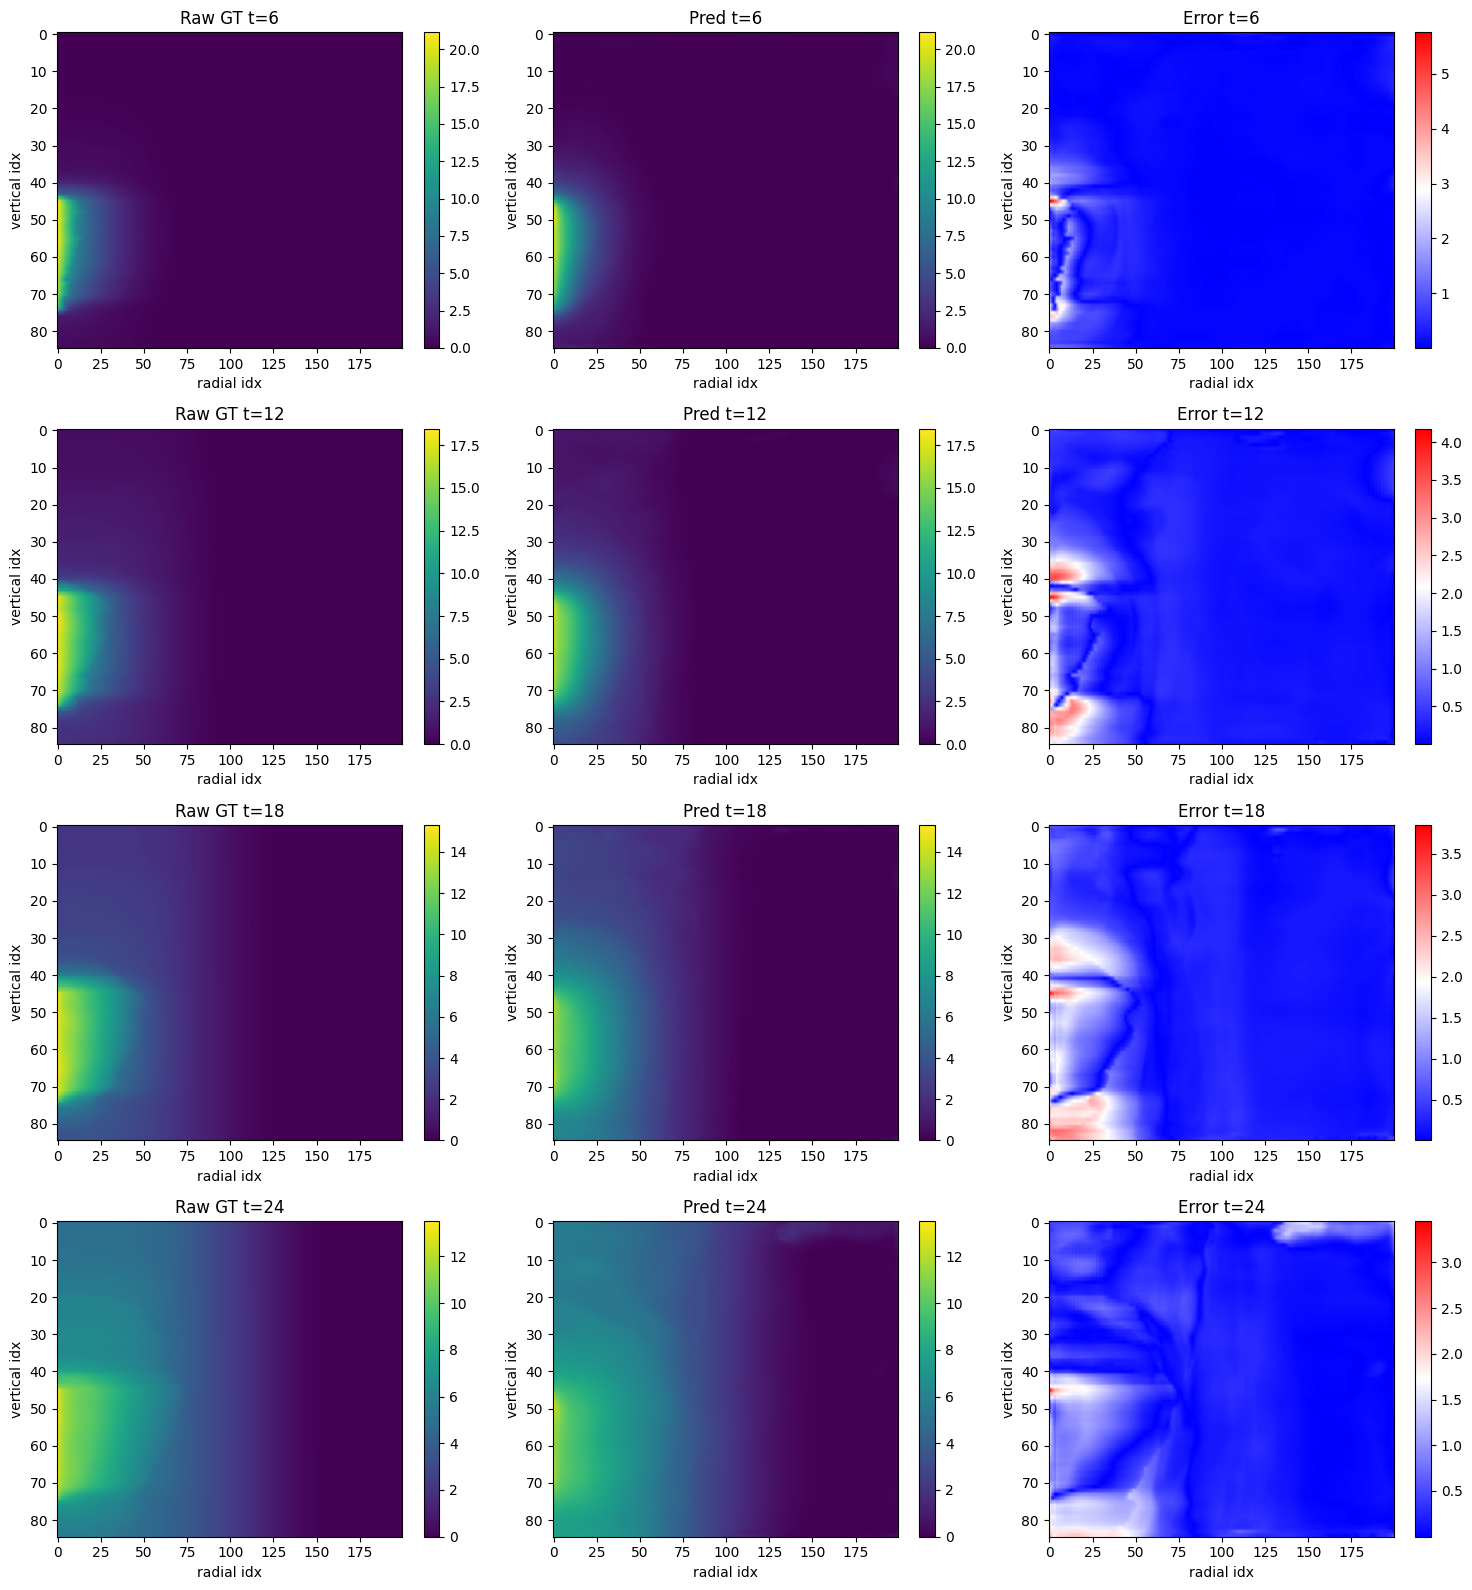

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) instantiate the exact same architecture you trained
model = Net3d(modes1=16, modes2=16, modes3=16, width=64).to(device)

# 3) load your checkpoint (mapping to current device)
ckpt_path = '/content/drive/MyDrive/best_model3.pth'
state    = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)

# 1) Grab the first batch *and* its index
#    We'll use enumerate to sync the sample with its path
for sample_idx, sample in enumerate(sample_loader):
    break  # only want the first one

# 2) Now get the exact path that produced it
path = sample_loader.dataset.paths[sample_idx]
h    = sample['original_height'].item()

# 3) Reload the *same* NPZ for its raw GT
with np.load(path) as d:
    raw = d[train_ds.target]    # shape (orig_H, W, T)

# 4) Forward‐pass & inverse‐z‐scale
x     = sample['inputs'].permute(0,3,4,2,1).to(device)
with torch.no_grad():
    y_std = model(x).squeeze(0)           # (H, W, T)
y_phys = np.zeros_like(y_std.cpu().numpy())
for t in range(raw.shape[-1]):
    μ, σ = raw[..., t].mean(), raw[..., t].std()
    y_phys[..., t] = y_std[..., t].cpu().numpy() * σ + μ

# 5) Now your raw and pred have matching heights
time_steps = [6,12,18,24]
indices    = [t-1 for t in time_steps]

fig, axes = plt.subplots(len(indices), 3, figsize=(15,4*len(indices)))
for i, idx in enumerate(indices):
    gt  = raw[:h, :, idx]      # (h, W)
    pr  = y_phys[:h, :, idx]   # (h, W)
    err = np.abs(gt - pr)

    vmax = gt.max()
    im0  = axes[i,0].imshow(gt,  vmin=0, vmax=vmax, aspect='auto')
    axes[i,0].set_title(f'Raw GT t={time_steps[i]}')
    plt.colorbar(im0, ax=axes[i,0])

    im1  = axes[i,1].imshow(pr,  vmin=0, vmax=vmax, aspect='auto')
    axes[i,1].set_title(f'Pred t={time_steps[i]}')
    plt.colorbar(im1, ax=axes[i,1])

    im2  = axes[i,2].imshow(err, cmap='bwr', aspect='auto')
    axes[i,2].set_title(f'Error t={time_steps[i]}')
    plt.colorbar(im2, ax=axes[i,2])

    for ax in axes[i]:
        ax.set_xlabel('radial idx')
        ax.set_ylabel('vertical idx')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
from sklearn.metrics import r2_score, mean_absolute_error

def denorm_np(std_arr, means, stds):
    out = np.zeros_like(std_arr)
    for t in range(std_arr.shape[-1]):
        out[..., t] = std_arr[..., t] * stds[t] + means[t]
    return out

r2_list  = []
mae_list = []

for idx in range(len(val_ds)):
    # 1) Reload raw GT volume and stats
    path   = val_ds.paths[idx]
    with np.load(path) as data:
        gt_vol    = data['pressure_buildup']   # (orig_H, orig_W, T)
    orig_H, orig_W, T = gt_vol.shape
    means =  gt_vol.mean(axis=(0,1))         # (T,)
    stds  =  gt_vol.std(axis=(0,1))          # (T,)

    # 2) Build and run the model input
    sample = val_ds[idx]
    x_in   = (sample['inputs']
              .unsqueeze(0)              # (1, C, T, H, W)
              .permute(0, 3, 4, 2, 1)    # → (1, H, W, T, C)
              .to(device))
    with torch.no_grad():
        model.eval()
        y_std = model(x_in).squeeze(0)       # (H, W, T)
    y_std_np = y_std.cpu().numpy()

    # 3) Denormalize
    y_phys_np = denorm_np(y_std_np, means, stds)

    # 4) Crop prediction to original height & width
    pr_cropped = y_phys_np[:orig_H, :orig_W, :]   # → (orig_H, orig_W, T)

    # 5) Flatten both arrays of the same shape
    gt_flat = gt_vol.reshape(-1)
    pr_flat = pr_cropped.reshape(-1)

    # 6) Compute metrics
    r2_list .append(r2_score(gt_flat, pr_flat))
    mae_list.append(mean_absolute_error(gt_flat, pr_flat))

# 7) Report
print(f"Average R²:  {np.mean(r2_list):.4f}")
print(f"Average MAE: {np.mean(mae_list):.4f}")


Average R²:  0.9724
Average MAE: 1.2900


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# 1) Instantiate your test dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_ds = PreprocessorAuto(
    split='test',
    sample_size=0,              # ignored for split='test'
    target='pressure_buildup',
    normalize=True,
    pad_mode='zero',
    H=96, W=200,
    seed=42,
    device=device
)

# 2) Load your trained model
model = Net3d(modes1=16, modes2=16, modes3=16, width=64).to(device)
ckpt = torch.load('/content/drive/MyDrive/best_model3.pth', map_location=device)
model.load_state_dict(ckpt)
model.eval()

# 3) Denormalization helper
def denorm_np(std_arr, means, stds):
    out = np.zeros_like(std_arr)
    for t in range(std_arr.shape[-1]):
        out[..., t] = std_arr[..., t] * stds[t] + means[t]
    return out

# 4) Visualize one sample (index 0)
time_steps = [6,12,18,24]
indices    = [t-1 for t in time_steps]

sample_idx = 0
sample     = test_ds[sample_idx]
path       = test_ds.paths[sample_idx]
h_orig     = sample['original_height']

# reload raw GT
with np.load(path) as d:
    raw = d['pressure_buildup']        # (H_orig, W_orig, T)
means =  raw.mean(axis=(0,1))
stds  =  raw.std(axis=(0,1))

# run model
x_in   = sample['inputs']\
             .unsqueeze(0)              # (1, C, T, H, W)
             .permute(0,3,4,2,1)        # → (1, H, W, T, C)
             .to(device)
with torch.no_grad():
    y_std = model(x_in).squeeze(0)      # (H, W, T)
y_phys = denorm_np(y_std.cpu().numpy(), means, stds)

# plotting
fig, axes = plt.subplots(len(indices), 3, figsize=(15,4*len(indices)))
for i, idx in enumerate(indices):
    gt  = raw[:h_orig, :, idx]
    pr  = y_phys[:h_orig, :, idx]
    err = np.abs(gt - pr)
    vmax = max(gt.max(), pr.max())

    im0 = axes[i,0].imshow(gt,  vmin=0, vmax=vmax, aspect='auto')
    axes[i,0].set_title(f'Raw GT t={time_steps[i]}')
    plt.colorbar(im0, ax=axes[i,0])

    im1 = axes[i,1].imshow(pr,  vmin=0, vmax=vmax, aspect='auto')
    axes[i,1].set_title(f'Pred t={time_steps[i]}')
    plt.colorbar(im1, ax=axes[i,1])

    im2 = axes[i,2].imshow(err, cmap='bwr', aspect='auto')
    axes[i,2].set_title(f'Error t={time_steps[i]}')
    plt.colorbar(im2, ax=axes[i,2])

    for ax in axes[i]:
        ax.set_xlabel('radial idx')
        ax.set_ylabel('vertical idx')

plt.tight_layout()
plt.show()

# 5) Compute and print metrics over the entire test set
r2_list, mae_list = [], []
for idx in range(len(test_ds)):
    # reload raw
    path   = test_ds.paths[idx]
    with np.load(path) as d:
        gt_vol = d['pressure_buildup']
    H_orig, W_orig, T = gt_vol.shape
    means = gt_vol.mean(axis=(0,1))
    stds  = gt_vol.std(axis=(0,1))

    # preprocess + forward
    sample = test_ds[idx]
    x_in   = (sample['inputs']
              .unsqueeze(0)
              .permute(0,3,4,2,1)
              .to(device))
    with torch.no_grad():
        y_std = model(x_in).squeeze(0)
    y_phys = denorm_np(y_std.cpu().numpy(), means, stds)

    # crop, flatten, score
    pr_crop = y_phys[:H_orig, :W_orig, :]
    r2_list.append(r2_score( gt_vol.reshape(-1),  pr_crop.reshape(-1)))
    mae_list.append(mean_absolute_error(gt_vol.reshape(-1), pr_crop.reshape(-1)))

print(f"\nTest  R² : {np.mean(r2_list):.4f}")
print(f"Test MAE: {np.mean(mae_list):.4f}")
